<h1 style="text-align: center;">SEMINARIO Nº2:</h1>
<h1 style="text-align: center;">Estabilidad química de fármacos</h1>

Se conoce por **estabilidad** a la capacidad de un IFA o medicamento de mantener sus propiedades originales, por un tiempo determinado y dentro de especificaciones de calidad requeridas. Si bien existen diversos tipos de estabilidad (ej.: física, biológica, toxicológica, biofarmacéutica, etc.), nos centraremos en analizar la ***estabilidad química*** de fármacos.

In [ ]:
!pip install rdkit
!pip install py3Dmol

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from IPython.display import SVG
import py3Dmol
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:

def MolTo3DView(smiles, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D

    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mol = Chem.MolFromSmiles(smiles)
    mol_opt = optimize_conf(mol)
    mblock = Chem.MolToMolBlock(mol_opt)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

def optimize_conf(mol):
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None

def construct_molecule_2d(smiles):
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol)

    return mol

def construct_molecule_2d(smiles):
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol)
    return mol

def hydrolysis_products(smiles):
    # Convertir SMILES a objeto molécula
    mol = Chem.MolFromSmiles(smiles)

    # Inicializar lista para almacenar productos de hidrólisis
    hydrolysis_products_list = []

    # Verificar si la molécula tiene un grupo éster
    ester_pattern = Chem.MolFromSmarts('[CX3:1](=[O:2])[OX2:3][C:4]')
    amide_pattern = Chem.MolFromSmarts('[CX3:1](=[O:2])[NX3,NX2,#7]')#[C:4]')
    #amide_pattern = Chem.MolFromSmarts('[CX3:1](=[O:2])[NX3;H1:3]')#[C:4]')

    if mol.HasSubstructMatch(ester_pattern):
        if not mol.HasSubstructMatch(amide_pattern):
            print('Posee un éster!')
            # Definir reacción de hidrólisis para éster
            rxn_smarts = '[CX3:1](=[O:2])[OX2:3][C:4].[OX2;H2:5]>>[CX3:1](=[O:2])[OX2;H1:3].[C:4][OX2;H1:5]'
            rxn = AllChem.ReactionFromSmarts(rxn_smarts)
            products = rxn.RunReactants((mol, Chem.MolFromSmiles('O')))
            for product in products:
                for p in product:
                    product_smiles = Chem.MolToSmiles(p)
                    hydrolysis_products_list.append(product_smiles)

    # Verificar si la molécula tiene un grupo amida
    if mol.HasSubstructMatch(amide_pattern) and not mol.HasSubstructMatch(ester_pattern):
      print('Posee una amida!')

      # Primera expresión de rxn_smarts
      rxn_smarts_1 = '[CX3:1](=[O:2])[NX3,NX2,#7;H1:3].[OX2;H2:5]>>[CX3:1](=[O:2])[OX2;H1:5].[NX3,NX2,#7;H2:3]'

      # Segunda expresión de rxn_smarts
      rxn_smarts_2 = '[CX3:1](=[O:2])[NX3,NX2,#7:3].[OX2;H2:5]>>[CX3:1](=[O:2])[OX2;H1:5].[NX3,NX2,#7;H1:3]'

      # Intentar con la primera expresión
      try:
          rxn = AllChem.ReactionFromSmarts(rxn_smarts_1)
          products = rxn.RunReactants((mol, Chem.MolFromSmiles('O')))

          if not products:
              # Si products está vacío, intentar con la segunda expresión
              rxn = AllChem.ReactionFromSmarts(rxn_smarts_2)
              products = rxn.RunReactants((mol, Chem.MolFromSmiles('O')))

              if not products:
                  print("Ambas expresiones de rxn_smarts no produjeron productos.")
              else:
                  #print("Se utilizó la segunda expresión exitosamente.")
                  # Resto del código utilizando rxn_smarts_2
                  for product in products:
                      for p in product:
                          product_smiles = Chem.MolToSmiles(p)
                          hydrolysis_products_list.append(product_smiles)
          else:
              #print("Se utilizó la primera expresión exitosamente.")
              # Resto del código utilizando rxn_smarts_1
              for product in products:
                  for p in product:
                      product_smiles = Chem.MolToSmiles(p)
                      hydrolysis_products_list.append(product_smiles)

      except Exception as e:
          print(f"Error al intentar la expresión: {e}")
          print("No se pudo construir rxn_smarts")



    if mol.HasSubstructMatch(ester_pattern):
        if mol.HasSubstructMatch(amide_pattern):
            print('Posee tanto éster como amida!')
            # Definir reacción de hidrólisis para éster
            rxn_smarts = '[CX3:1](=[O:2])[OX2:3][C:4].[OX2;H2:5]>>[CX3:1](=[O:2])[OX2;H1:3].[C:4][OX2;H1:5]'
            rxn = AllChem.ReactionFromSmarts(rxn_smarts)
            products = rxn.RunReactants((mol, Chem.MolFromSmiles('O')))
            for product in products:
                for p in product:
                    product_smiles = Chem.MolToSmiles(p)
                    hydrolysis_products_list.append(product_smiles)
            for product_smiles in hydrolysis_products_list:
                product_mol = Chem.MolFromSmiles(product_smiles)
                rxn_smarts_amide = '[CX3:1](=[O:2])[NX3;H1:3].[OX2;H2:5]>>[CX3:1](=[O:2])[OX2;H1:5].[NX3;H2:3]'
                rxn_amide = AllChem.ReactionFromSmarts(rxn_smarts_amide)
                products_amide = rxn_amide.RunReactants((product_mol, Chem.MolFromSmiles('O')))
                for product_amide in products_amide:
                    for p_amide in product_amide:
                        product_amide_smiles = Chem.MolToSmiles(p_amide)
                        hydrolysis_products_list.append(product_amide_smiles)

    print("Reactivo")
    mol2d = construct_molecule_2d(input_smiles)
    display(mol2d)
    viewer = MolTo3DView(input_smiles, surface=False)
    viewer.show()
    print("Producto(s)")
    for unique_product in hydrolysis_products_list:
        mol2d = construct_molecule_2d(unique_product)
        display(mol2d)
        viewer = MolTo3DView(unique_product, surface=False)
        viewer.show()

    #return hydrolysis_products_list

def oxidize_molecule(input_smiles):
    mol = Chem.MolFromSmiles(input_smiles)

    # Verificar si la molécula tiene un grupo éster
    catecol_pattern1 = Chem.MolFromSmarts('[CX3,#6:1]([OH:2])=[#6:3]([OH:4])')
    catecol_pattern2 = Chem.MolFromSmarts('[CX3,#6:1]([OH:2])[#6:3]([OH:4])')

    # Inicializar conjuntos de productos
    unique_products1 = set()
    unique_products2 = set()

    if mol.HasSubstructMatch(catecol_pattern1) or mol.HasSubstructMatch(catecol_pattern2):
        #print('es catecol')

        # Intentar con la primera reacción SMARTS
        rxn_smarts1 = '[CX3,#6:1]([OH:2])=[CX3,#6:3]([OH:4])>>[CX3,#6:1](=[O:2])[CX3,#6:3](=[O:4])'
        rxn1 = AllChem.ReactionFromSmarts(rxn_smarts1)
        products1 = rxn1.RunReactants((mol,))
        for product1 in products1:
            for p1 in product1:
                product_smiles1 = Chem.MolToSmiles(p1)
                #print(product_smiles1)
                unique_products1.add(product_smiles1)

        # Verificar si la primera reacción no generó productos y, en ese caso, intentar con la segunda reacción
        if not unique_products1:
            rxn_smarts2 = '[CX3,#6:1]([OH:2])[CX3,#6:3]([OH:4])>>[CX3,#6:1](=[O:2])[CX3,#6:3](=[O:4])'
            rxn2 = AllChem.ReactionFromSmarts(rxn_smarts2)
            products2 = rxn2.RunReactants((mol,))
            for product2 in products2:
                for p2 in product2:
                    product_smiles2 = Chem.MolToSmiles(p2)
                    #print(product_smiles2)
                    unique_products2.add(product_smiles2)
    # Mostrar las imágenes 2D y 3D de los productos únicos
    for unique_product in unique_products1.union(unique_products2):
        print("Reactivo")
        mol2d = construct_molecule_2d(input_smiles)
        display(mol2d)
        viewer = MolTo3DView(input_smiles, surface=False)
        viewer.show()
        print("Producto(s)")
        mol2d = construct_molecule_2d(unique_product)
        display(mol2d)
        viewer = MolTo3DView(unique_product, surface=False)
        viewer.show()

# **Reacciones de degradación de fármacos**

Utilizaremos las siguientes funciones para identificar si los compuestos de interés poseen o no grupos hidrolizables u oxidables; y posteriormente podremos visualizar la estructura 2D y 3D de los productos de degradación.

La función *hydrolysis_products(input_smiles)* necesita como input el SMILES de la molécula a analizar, y genera como resultados la estructura 3D tanto del reactivo como de sus productos.

Podemos evaluar los compuestos uno a uno, tal como se ejemplifica abajo:

Posee un éster!
Reactivo


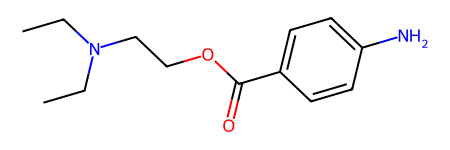

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Producto(s)


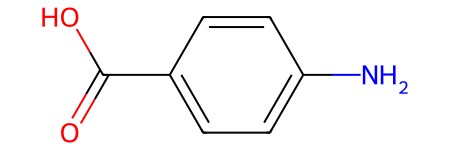

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

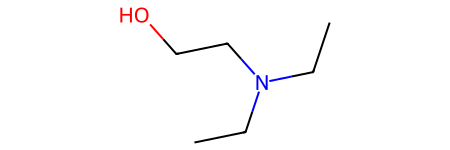

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [4]:
input_smiles = "O=C(OCCN(CC)CC)C1=CC=C(N)C=C1"
hydrolysis_products(input_smiles)

O analizar el set completo, aplicando lo que se conoce como '*loop for*':

In [5]:
data_mols = {'mols': ['O=C(OCCN(CC)CC)C1=CC=C(N)C=C1', 'O=C(NCCN(CC)CC)C1=CC=C(N)C=C1',
'O=C(NCCN(CC)CC)C1=CC(Cl)=C(N)C=C1OC',
'COC1=CC=C(N(C(C2=CC=C(Cl)C=C2)=O)C(C)=C3CC(O)=O)C3=C1',
'OC1=C(O)C=C(C[C@@H](C(O)=O)N)C=C1',
'NC1=CC=C(S(NC(C)=O)(=O)=O)C=C1',
'CC(C)C1=C(C(=C(N1CCC(CC(CC(=O)O)O)O)C2=CC=C(C=C2)F)C3=CC=CC=C3)C(=O)NC4=CC=CC=C4',
'O=C1C(O)=C(O)C(C(CO)O)O1']}
df = pd.DataFrame(data_mols)

Posee un éster!
Reactivo


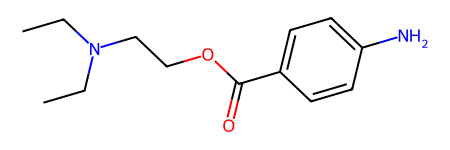

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Producto(s)


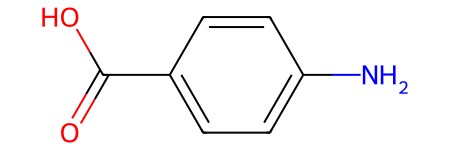

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

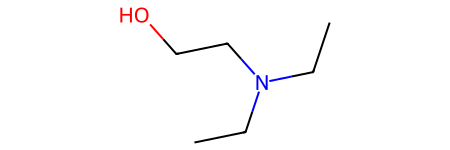

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Posee una amida!
Reactivo


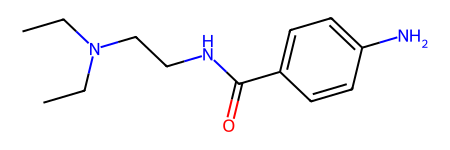

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Producto(s)


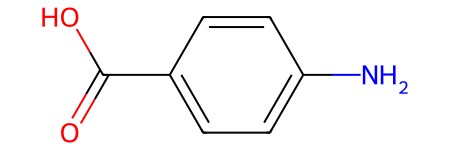

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

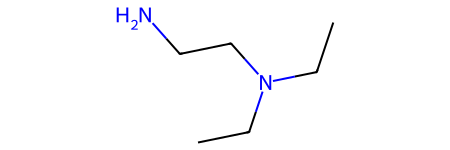

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Posee una amida!
Reactivo


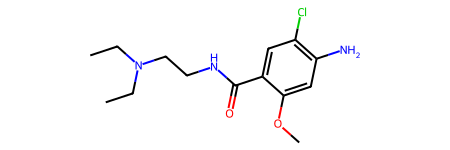

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Producto(s)


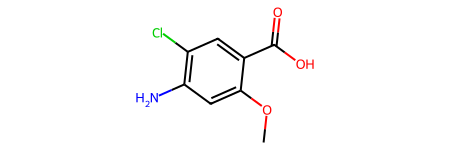

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

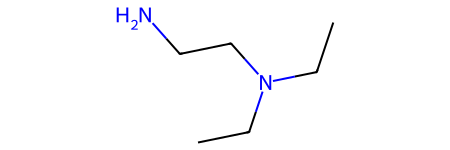

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Posee una amida!
Reactivo


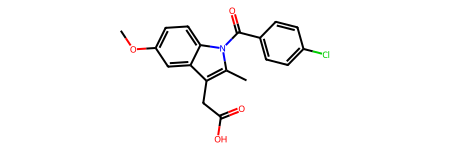

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Producto(s)


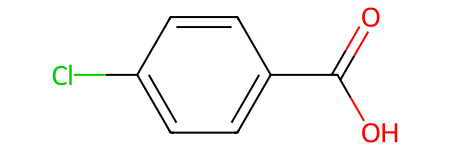

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

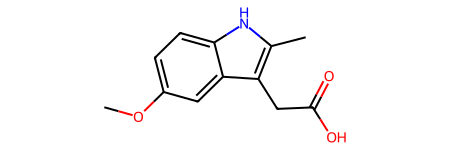

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Reactivo


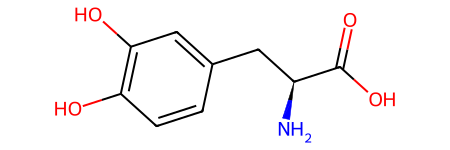

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Producto(s)
Posee una amida!
Reactivo


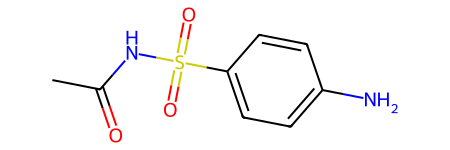

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Producto(s)


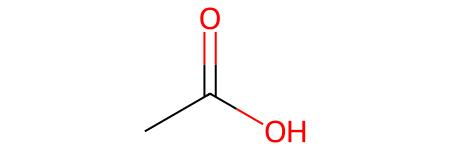

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

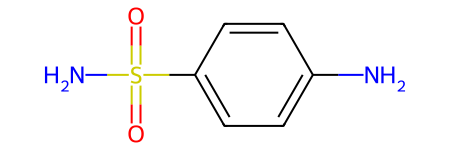

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Posee una amida!
Reactivo


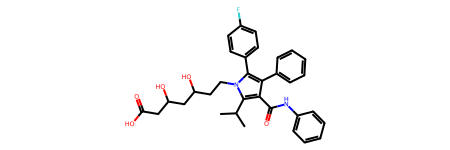

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Producto(s)


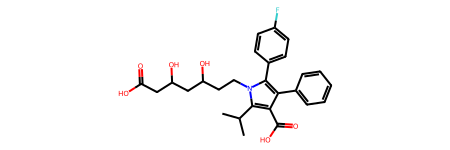

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

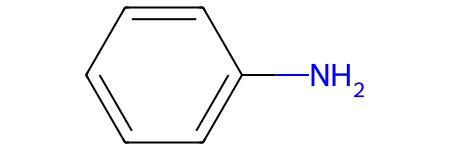

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Posee un éster!
Reactivo


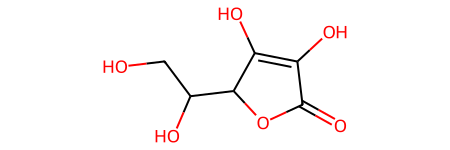

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Producto(s)


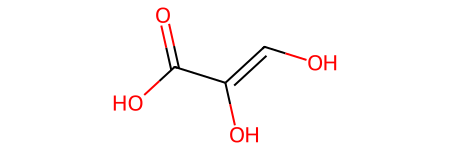

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

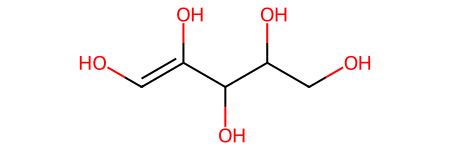

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [6]:
for input_smiles in df['mols']:
  hydrolysis_products(input_smiles)

De manera análoga, podemos analizar ahora los fármacos susceptibles a sufrir oxidación, empleando la función oxidize_molecule()

Reactivo


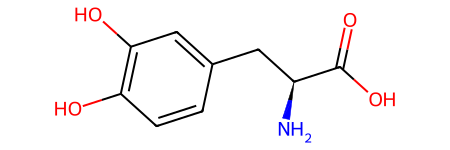

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Producto(s)


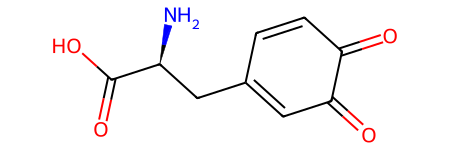

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [7]:
input_smiles = "OC1=C(O)C=C(C[C@@H](C(O)=O)N)C=C1"
oxidize_molecule(input_smiles)

Reactivo


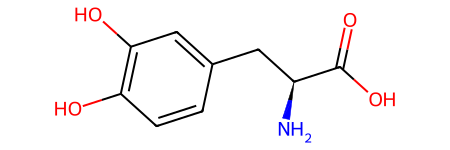

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Producto(s)


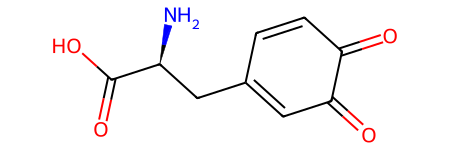

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Reactivo


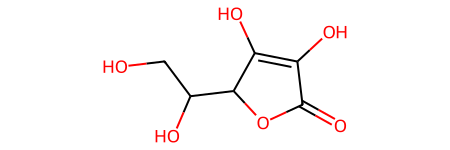

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Producto(s)


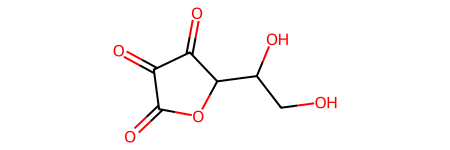

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [8]:
for input_smiles in df['mols']:
  oxidize_molecule(input_smiles)

# **Cinética Química**

Además de identificar grupos funcionales susceptibles a la degradación química, es de relevancia farmacéutica conocer la velocidad con la que se producen las reacciones de degradación; principalmente para definir períodos en los que fármacos/medicamentos puedan usarse de manera segura. Para ello, es necesario trabajar con conceptos asociados a la **cinética química**.

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.stats import linregress


def calcular_concentracion(absorbancia, coef_extincion=1, longitud_camino=1):
    concentracion = absorbancia / (longitud_camino * coef_extincion)
    return concentracion

def generar_dataframe_desde_Abs(df, coef_extincion=1, longitud_camino=1):
    if 'concentracion' not in df.columns:
        df['concentracion'] = calcular_concentracion(df['absorbancia'], coef_extincion, longitud_camino)
        df['ln_concentracion'] = np.log(df['concentracion'])
        df['inversa_concentracion'] = 1 / df['concentracion']
    print(df)
    return df

def cinetica_orden_cero(t, c0, k):
    return c0 - k * t

def ajustar_cinetica_orden_cero(tiempo, concentracion):
    parametros_iniciales = [concentracion.iloc[0], 0.001]
    parametros_optimizados, matriz_covarianza = curve_fit(cinetica_orden_cero, tiempo, concentracion, p0=parametros_iniciales)

    concentracion_ajustada = cinetica_orden_cero(tiempo, *parametros_optimizados)
    r2 = r2_score(concentracion, concentracion_ajustada)

    return parametros_optimizados[0], parametros_optimizados[1], r2

def cinetica_orden_uno(t, c0, k):
    return c0 - k * t

def ajustar_cinetica_orden_uno(tiempo, concentracion_ln):
    slope, intercept, r_value, p_value, std_err = linregress(tiempo, concentracion_ln)
    r2 = r_value**2

    return intercept, -slope, r2

def cinetica_orden_dos(t, c0, k):
    return (1 / c0) + k * t

def ajustar_cinetica_orden_dos(tiempo, inversa_concentracion):
    parametros_iniciales = [1 / inversa_concentracion.iloc[0], 0.001]
    parametros_optimizados, matriz_covarianza = curve_fit(cinetica_orden_dos, tiempo, inversa_concentracion, p0=parametros_iniciales)

    concentracion_ajustada = cinetica_orden_dos(tiempo, *parametros_optimizados)
    r2 = r2_score(inversa_concentracion, concentracion_ajustada)

    return parametros_optimizados[0], parametros_optimizados[1], r2

def graficar_cineticas(tiempo, datos, parametros_optimizados, orden, color_puntos='blue', color_linea='red'):
    tiempo = np.array(tiempo)
    datos = np.array(datos)

    plt.subplot(1, 3, orden)
    sns.scatterplot(x=tiempo, y=datos, label='Datos experimentales', color=color_puntos)
    plt.xlabel('Tiempo')

    if orden == 1:
        plt.ylabel('Concentración')
        plt.plot(tiempo, cinetica_orden_cero(tiempo, *parametros_optimizados[:2]), label='Ajuste de orden cero', color=color_linea)
        plt.legend().set_visible(False)

    elif orden == 2:
        plt.ylabel('ln(Concentración)')
        plt.plot(tiempo, cinetica_orden_uno(tiempo, *parametros_optimizados[:2]), label='Ajuste de orden uno', color=color_linea)
        plt.legend().set_visible(False)

    elif orden == 3:
        plt.ylabel('1 / Concentración')
        plt.plot(tiempo, cinetica_orden_dos(tiempo, *parametros_optimizados[:2]), label='Ajuste de orden dos', color=color_linea)
        plt.legend().set_visible(False)

    k_cientifico = '{:.2e}'.format(parametros_optimizados[1])

    if orden == 1 or orden == 2:
        texto = f'k: {k_cientifico}\nOrdenada al origen: {parametros_optimizados[0]:.4f}\n$r^2$: {parametros_optimizados[2]:.4f}'
    else:
        texto = f'k: {k_cientifico}\nOrdenada al origen: {(1/parametros_optimizados[0]):.4f}\n$r^2$:{parametros_optimizados[2]:.4f}'

    plt.annotate(texto, xy=(0.3, 0.85), xycoords='axes fraction', fontsize=10, color='black')

    # Anotaciones con valores de k, ordenada al origen y r2
    #k_cientifico = '{:.2e}'.format(parametros_optimizados[1])
    #texto = f'k: {k_cientifico}\nOrdenada al origen: {parametros_optimizados[0]:.4f}\n$r^2$: {parametros_optimizados[2]:.4f}'
    #plt.annotate(texto, xy=(0.3, 0.85), xycoords='axes fraction', fontsize=10, color='black')


# Ejemplo de uso
def analizar_cineticas(df, coef_extincion=1, longitud_camino=1):
    df = generar_dataframe_desde_Abs(df, coef_extincion, longitud_camino)

    # Orden 0
    constante_ajuste_0, ordenada_al_origen_ajuste_0, r2_ajuste_0 = ajustar_cinetica_orden_cero(df['tiempo'], df['concentracion'])
    print("Orden 0:")
    print(f"Ordenada al origen de ajuste: {constante_ajuste_0}")
    print(f"Constante de ajuste: {ordenada_al_origen_ajuste_0}")
    print(f"Coeficiente de determinación (r²): {r2_ajuste_0}")

    # Orden 1
    constante_ajuste_1, ordenada_al_origen_ajuste_1, r2_ajuste_1 = ajustar_cinetica_orden_uno(df['tiempo'], np.log(df['concentracion']))
    print("\nOrden 1:")
    print(f"Ordenada al origen de ajuste: {constante_ajuste_1}")
    print(f"Constante de ajuste: {ordenada_al_origen_ajuste_1}")
    print(f"Coeficiente de determinación (r²): {r2_ajuste_1}")

    # Orden 2
    constante_ajuste_2, ordenada_al_origen_ajuste_2, r2_ajuste_2 = ajustar_cinetica_orden_dos(df['tiempo'], 1 / df['concentracion'])
    print("\nOrden 2:")
    print(f"Ordenada al origen de ajuste: {1/constante_ajuste_2}")
    print(f"Constante de ajuste: {ordenada_al_origen_ajuste_2}")
    print(f"Coeficiente de determinación (r²): {r2_ajuste_2}")

    # Gráficos
    plt.figure(figsize=(15, 5))

    graficar_cineticas(df['tiempo'], df['concentracion'], [constante_ajuste_0, ordenada_al_origen_ajuste_0, r2_ajuste_0], 1, color_puntos='blue', color_linea='blue')
    graficar_cineticas(df['tiempo'], np.log(df['concentracion']), [constante_ajuste_1, ordenada_al_origen_ajuste_1, r2_ajuste_1], 2, color_puntos='green', color_linea='green')
    graficar_cineticas(df['tiempo'], 1 / df['concentracion'], [constante_ajuste_2, ordenada_al_origen_ajuste_2, r2_ajuste_2], 3, color_puntos='red', color_linea='red')

    plt.tight_layout()
    plt.show()

    # Comparación de r2 y determinación del orden
    r2_values = [r2_ajuste_0, r2_ajuste_1, r2_ajuste_2]
    ordenes = ['Orden 0', 'Orden 1', 'Orden 2']
    mejor_orden = ordenes[np.argmax(r2_values)]

    print(f"\nMejor orden de reacción: {mejor_orden}")


def calcular_tiempo_vida_media(orden_reaccion, k, c0, t50):
    if orden_reaccion == 1:
        if k == 'no':
            k_calc = np.log(2) / t50
            t50_calc=t50
            c0_calc=c0
        if t50 == 'no':
            t50_calc = np.log(2) / k
            k_calc=k
            c0_calc=c0
    elif orden_reaccion == 2:
        if k == 'no':
            k_calc = 1 / (t50 * c0)
            t50_calc=t50
            c0_calc = c0
        if t50 == 'no':
            t50_calc = 1 / (k * c0)
            k_calc=k
            c0_calc = c0
        if c0 == 'no':
            c0_calc = 1 / (t50 * k)
            k_calc=k
            t50_calc=t50
    elif orden_reaccion == 0:
        if k == 'no':
            k_calc = c0 / (t50 * 2)
            t50_calc=t50
            c0_calc = c0
        if t50 == 'no':
            t50_calc = c0 / (2 * k)
            k_calc=k
            c0_calc = c0
        if c0 == 'no':
            c0 = t50 * 2 * k
            k_calc=k
            t50_calc=t50
    return k_calc, c0_calc, t50_calc

def calcular_tiempo_vida_util(orden_reaccion, k, c0, t90):
    if orden_reaccion == 1:
        if k == 'no':
            k_calc = np.log(0.9)*-1 / t90
            t90_calc=t90
            c0_calc=c0
        if t90 == 'no':
            t90_calc = np.log(0.9)*-1/ k
            k_calc=k
            c0_calc=c0
    elif orden_reaccion == 2:
        if k == 'no':
            k_calc = ((1/0.9)-1) / (t90 * c0)
            t90_calc=t90
            c0_calc = c0
        if t90 == 'no':
            t90_calc = ((1/0.9)-1) / (k * c0)
            k_calc=k
            c0_calc = c0
        if c0 == 'no':
            c0_calc = ((1/0.9)-1) / (t90 * k)
            k_calc=k
            t90_calc=t90
    elif orden_reaccion == 0:
        if k == 'no':
            k_calc = (c0*0.1) / (t90)
            t90_calc=t90
            c0_calc = c0
        if t90 == 'no':
            t90_calc = (c0*0.1) / (k)
            k_calc=k
            c0_calc = c0
        if c0 == 'no':
            c0 = (t90 * k)/0.1
            k_calc=k
            t90_calc=t90
    return k_calc, c0_calc, t90_calc

Como sabemos, para determinar el orden de una reacción necesitamos información de cómo varía la concentración en función del tiempo. Utilizando la función *analizar_cineticas()* podremos obtener los resultados directamente, tan solo generando la tabla o el *dataframe* correspondiente.

   tiempo  concentracion
0       0       230.0000
1       3       228.1359
2       6       227.2883
3      10       226.3333
4      30       220.6868
5      50       207.3255
6      70       198.4291
7      90       190.2132
Orden 0:
Ordenada al origen de ajuste: 230.53227528823297
Constante de ajuste: 0.4472822483125578
Coeficiente de determinación (r²): 0.9903576425756198

Orden 1:
Ordenada al origen de ajuste: 5.441950557743643
Constante de ajuste: 0.0021225628265718597
Coeficiente de determinación (r²): 0.9887763792583348

Orden 2:
Ordenada al origen de ajuste: 0.004323185711088457
Constante de ajuste: 1.0097057998872178e-05
Coeficiente de determinación (r²): 0.986330291953919


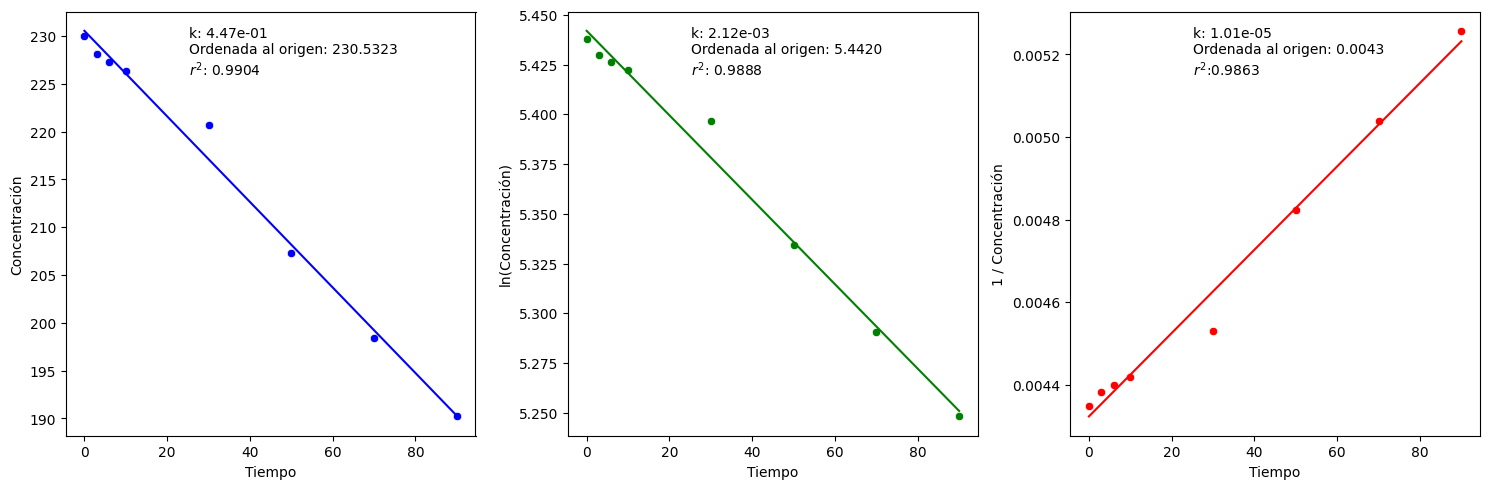


Mejor orden de reacción: Orden 0


In [10]:
# Ejemplo de uso con concentración
data_concentracion = {'tiempo': [0, 3, 6, 10, 30, 50, 70, 90],
                      'concentracion': [230, 228.1359, 227.2883, 226.3333, 220.6868, 207.3255, 198.4291, 190.2132]}
df_concentracion = pd.DataFrame(data_concentracion)

analizar_cineticas(df_concentracion)

Sin embargo, en la práctica se suelen emplear diversas metodologías para determinar esas concentraciones. Una de las más económicas y versátiles es la absorbancia UV-Visible. Gracias a la Ley de Lambert & Beer sabemos que - bajo ciertas condiciones - absorbancia es es directamente proporcional a concentración.

En este contexto, la función *analizar_cineticas()* también nos brinda la posibilidad de determinar órdenes de reacción a partir de Abs, debiendo especificar para ello los valores del coeficiente de absortividad molar o de extinción y el paso de celda.

   tiempo  absorbancia  concentracion  ln_concentracion  inversa_concentracion
0       0         0.83       0.000203         -8.500182            4915.662651
1      20         0.71       0.000174         -8.656343            5746.478873
2      40         0.60       0.000147         -8.824678            6800.000000
3      70         0.55       0.000135         -8.911689            7418.181818
4      90         0.47       0.000115         -9.068875            8680.851064
5     120         0.41       0.000100         -9.205450            9951.219512
6     150         0.32       0.000078         -9.453287           12750.000000
7     180         0.24       0.000059         -9.740969           17000.000000
Orden 0:
Ordenada al origen de ajuste: 0.00018951458632976453
Constante de ajuste: 7.520325204139354e-07
Coeficiente de determinación (r²): 0.9742332647960503

Orden 1:
Ordenada al origen de ajuste: -8.504789469753705
Constante de ajuste: 0.006452471992845117
Coeficiente de determinación 

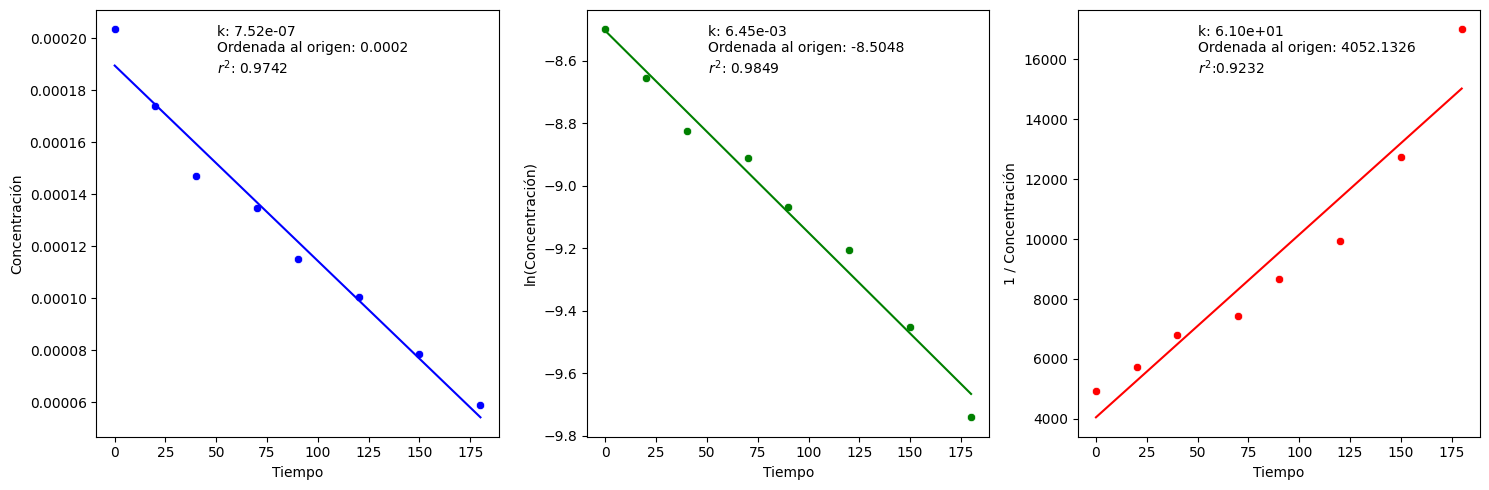


Mejor orden de reacción: Orden 1


In [11]:
# Ejemplo de uso con absorbancia
data_absorbancia = {'tiempo': [0, 20, 40, 70, 90, 120, 150, 180],
                    'absorbancia': [0.83, 0.71, 0.60, 0.55, 0.47, 0.41, 0.32, 0.24]}
df_absorbancia = pd.DataFrame(data_absorbancia)

# Puedes proporcionar el coeficiente de extinción y la longitud de camino como argumentos adicionales
coef_extincion = 3400
paso_celda = 1.20

analizar_cineticas(df_absorbancia, coef_extincion, paso_celda)

Además de determinar órdenes de reacción y constantes de velocidad, hay otros parámetros cinéticos que son de relevancia en Farmacia. Entre ellos destacan los tiempos de vida media y tiempos de vida útil.

Las funciones *calcular_tiempo_vida_util()* y *calcular_tiempo_vida_media()* nos permiten obtener esos valores. Considerando que según el orden de reacción la fórmula cambia, es necesario proveerles 4 inputs:
- Orden de reacción: 0, 1 o 2.
- Constante de velocidad
- Concentración inicial (cuando corresponda)
- Tiempo de vida media o útil.


A modo de ejemplo, consideremos que sabemos que una reacción de hidrólisis sigue un orden 1, con una k = 1.5e-05 s-1 a 25ºC. Si queremos conocer el tiempo de vida útil aplicando la función deberíamos aplicar:

In [12]:
k_calc, c0_calc, t90_calc  = calcular_tiempo_vida_util(1,1.5e-05,'','no')
print(t90_calc)

7024.034377188418


En este caso, dejamos vacía ('') concentración inicial ya que para el cálculo de este tiempo para una reacción de Orden 1 no es necesario. E indicamos 'no' en el correspondiente a tiempo porque es el dato que NO tenemos.

¿Cómo la aplicaríamos si el orden de reacción fuese 0 con una concentración inicial de 0.4M?


In [13]:
k_calc, c0_calc, t90_calc  = calcular_tiempo_vida_util(0,1.5e-05,0.4,'no')
print(t90_calc)

2666.666666666667


Y si conociéramos que una reacción X sigue un orden 1 y a 25ºC tiene un t1/2 de 10000min, esta función nos permite conocer la constante de velocidad a esa temperatura según:

In [14]:
k_calc, c0_calc, t90_calc  = calcular_tiempo_vida_util(1,'no','',10000)
print(k_calc)

1.0536051565782628e-05


Así pues, esta misma función nos permite calcular tiempos de vida media o util, concentraciones iniciales y/o constantes de velocidad a una temperatura determinada según los datos con los que contemos.

# **Condiciones que afectan estabilidad: Temperatura**

Gracias a la ecuación de Arrhenius podemos determinar numerosos parámetros cinéticos de relevancia trabajando a distintas temperaturas. Entre ellos, constantes de velocidad (k), energías de activación (Ea) y factor de colisiones (A). Dada su versatilidad e importancia se han definido distintas funciones que permitan obtener información variada según las necesidades y los datos con los que contamos.

In [15]:
#ARRHENIUS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

def preparar_dataframe(arrhenius_data, temp_unit='C'):
    # Crear DataFrame original
    arrhenius_data_df = pd.DataFrame(arrhenius_data)

    # Convertir temperatura a Kelvin si es necesario
    if temp_unit == 'C':
        arrhenius_data_df['Temperature_K'] = arrhenius_data_df['Temperature'] + 273.15
    elif temp_unit == 'K':
        arrhenius_data_df['Temperature_K'] = arrhenius_data_df['Temperature']

    # Agregar columnas al nuevo DataFrame
    arrhenius_data_df['ln_k'] = np.log(arrhenius_data_df['k'])
    arrhenius_data_df['1_over_T'] = 1 / arrhenius_data_df['Temperature_K']

    return arrhenius_data_df

def arrhenius_equation(T, A, Ea_over_R):
    return A * np.exp(-Ea_over_R / T)

def linealizar_arrhenius(T, k):
    # Linealizar ln(k) = -Ea/R * 1/T + ln(A)
    inv_T = 1 / T
    ln_k = np.log(k)

    # Ajuste lineal
    slope, intercept, r_value, p_value, std_err = linregress(inv_T, ln_k)

    # Pendiente representa -Ea/R
    Ea_over_R = -slope
    Ea = Ea_over_R*1.987

    return slope, intercept, Ea_over_R, r_value, Ea

def graficar_arrhenius(data_df):
    sns.set(style="white")  # Configuración del estilo de Seaborn

    # Linealizar los datos
    slope, intercept, Ea_over_R, r_value, Ea = linealizar_arrhenius(data_df['Temperature_K'].values, data_df['k'].values)

    # Graficar los datos y ajuste lineal
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data_df['1_over_T'], y=np.log(data_df['k']), label='Datos experimentales', color='blue')

    # Corregir la generación de la línea de ajuste lineal
    arrhenius_line = slope * data_df['1_over_T'].values + intercept
    plt.plot(data_df['1_over_T'].values, arrhenius_line, color='red', label='Ajuste lineal')

    plt.xlabel('1 / Temperatura (1/K)')
    plt.ylabel('ln(k)')
    plt.legend()

    plt.title(f'Ajuste Lineal de la Ecuación de Arrhenius\n$E_a/R$: {Ea_over_R:.2f}, $E_a$: {Ea:.2f}, $R^2$: {r_value**2:.2f}')

    # Imprimir valores de Ea y ordenada al origen
    print(f'Ea/R: {Ea_over_R:.4f}')
    print(f'Ea: {Ea:.4f}')
    print(f'Ordenada al origen (ln(A)): {intercept:.4f}')
    # Calcular e^x
    resultado = np.exp(intercept)

    # Imprimir el resultado
    print(f'A = {resultado}')

    plt.show()

def calcular_Ea(T1, T2, k1, k2, R=1.987):
    return R * np.log(k2 / k1) / (1 / T1 - 1 / T2)

def calcular_k(Ea, T1, T2, k1, R=1.987):
    return k1 * np.exp((Ea/R) * ((1 / T1) - (1 / T2)))

Una posibilidad es contar con datos de constantes de velocidad a distintas temperaturas, y querer conocer los valores de Ea y/o A.

Hay que tener en cuenta que la ecuación de Arrhenius necesita que las T estén expresadas en grados Kelvin. Para simplicar el cálculo, la función directamente convierte los datos, siempre y cuando se especifique la unidad de temperatura, tal como se ejemplifica abajo.

Ea/R: 7864.4043
Ea: 15626.5714
Ordenada al origen (ln(A)): 24.2897
A = 35390598003.73428


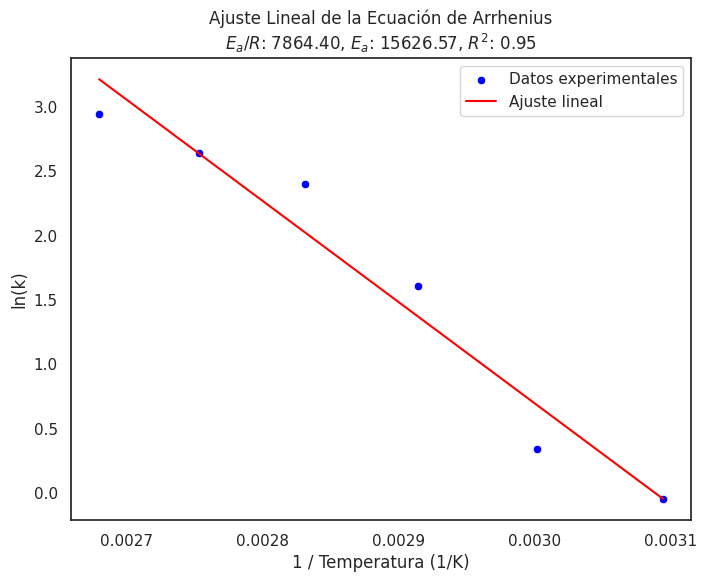

In [16]:
# Ejemplo de uso
arrhenius_data = {'k': [19, 14, 11, 5, 1.4, 0.95],
                  'Temperature': [100, 90, 80, 70, 60, 50]}

arrhenius_data_C = pd.DataFrame(arrhenius_data)

arrhenius_data_df_C = preparar_dataframe(arrhenius_data_C, temp_unit='C')

graficar_arrhenius(arrhenius_data_df_C)

De manera análoga, si ya contamos con los valores en grados Kelvin, deberíamos aplicar la función especificando K en vez de C, de la siguiente manera:

Ea/R: 7864.4043
Ea: 15626.5714
Ordenada al origen (ln(A)): 24.2897
A = 35390598003.73428


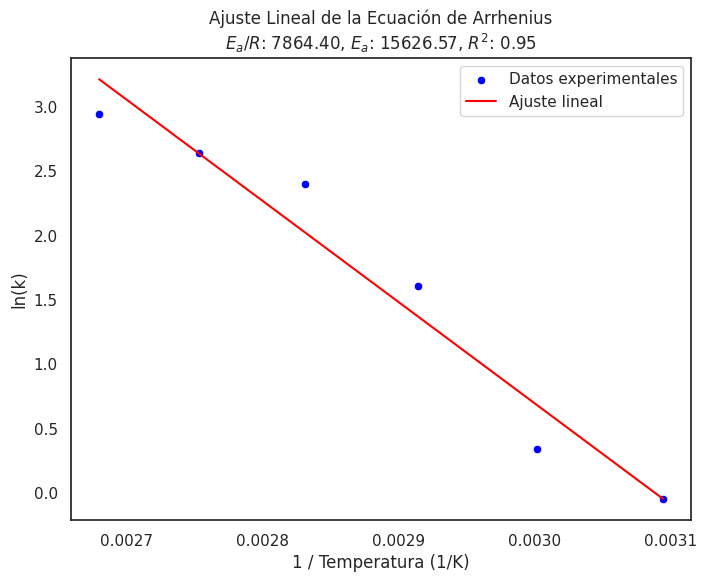

In [17]:
arrhenius_data = {'k': [19, 14, 11, 5, 1.4, 0.95],
                  'Temperature': [373.15, 363.15, 353.15, 343.15, 333.15, 323.15]}

arrhenius_data_K = pd.DataFrame(arrhenius_data)

arrhenius_data_df_K = preparar_dataframe(arrhenius_data_K, temp_unit='K')

graficar_arrhenius(arrhenius_data_K)

Otro uso ampliamente asignado a la ecuación de Arrhenius es el Método de Degradación Acelerada, que nos permite identificar rápidamente parámetros cinéticos de interés tales como constantes de velocidad o Energía de activación trabajando a altas temperaturas.

Los datos necesarios para aplicar este método son:
- Dos valores de constantes de velocidad (k1 y k2) a dos temperaturas diferentes (T1 y T2).
- Energía de activación.

Cuando alguno de esos valores sea desconocido, se puede usar la ecuación para calcularlo. Por lo tanto, hemos desarrollado dos funciones para ello, denominadas *calcular_Ea()* y *calcular_k2()*

Entonces, si conocemos los pares k1-T1 y k2-T2, podremos calcular la Ea de la reacción según:

In [18]:
#Ejemplo de uso
T1 = 273.15 + 80 #Tiene que estar en K!
T2 = 273.15 + 45 #Tiene que estar en K!
k1 = 0.0000766
k2 = 0.00000941

Ea_calculada = calcular_Ea(T1, T2, k1, k2)

print(f'Ea calculada: {Ea_calculada:.4f} cal/mol')

Ea calculada: 13374.6666 cal/mol


Y si ahora queremos conocer la constante de velocidad a otra temperatura (ej.: 25ºC), podemos aplicar:

In [19]:
T3 = 273.15 + 25 #Tiene que estar en K!

k3_calculada = calcular_k(Ea_calculada, T1, T3, k1)
print(f'k3 calculada: {k3_calculada}')

k3 calculada: 2.2763139156681585e-06


Podríamos corroborar el resultado usando el otro par k-T.

In [20]:
T3 = 273.15 + 25 #Tiene que estar en K!

k3_calculada = calcular_k(Ea_calculada, T2, T3, k2)
print(f'k3 calculada: {k3_calculada}')

k3 calculada: 2.2763139156681602e-06
